<a href="https://colab.research.google.com/github/kidrono/AutoMix-DMC-implementation/blob/main/dmc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import os
from torch import nn
import tarfile
from pathlib import Path
import matplotlib.pyplot as plt
import glob
import torchaudio
from IPython.display import Audio

In [2]:
data_path = Path("data")

if data_path.is_dir():
  print("already exists")
else:
  data_path.mkdir(parents=True, exist_ok=True)

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
!gdown "1F_dYm6pKNEcDXdK87tAFByNU1pqwi9qp&confirm=t"

Downloading...
From: https://drive.google.com/uc?id=1F_dYm6pKNEcDXdK87tAFByNU1pqwi9qp&confirm=t
To: /content/ENST-drums.tar
100% 5.28G/5.28G [00:54<00:00, 97.7MB/s]


In [5]:
drum_path = data_path / "ENST-drums"

if drum_path.is_dir():
  print("already exists")
else:
  with tarfile.open("ENST-drums.tar", 'r') as tar_ref:
    tar_ref.extractall(data_path)

In [6]:
def walk_through_dir(dir_path):
  for dirpath, dirname, filename in os.walk(dir_path):
    print(f"There are {len(dirname)} directories and {len(filename)} files in {dirpath}")

In [7]:
walk_through_dir(drum_path)

There are 3 directories and 1 files in data/ENST-drums
There are 2 directories and 0 files in data/ENST-drums/drummer_2
There are 10 directories and 0 files in data/ENST-drums/drummer_2/audio
There are 0 directories and 105 files in data/ENST-drums/drummer_2/audio/accompaniment
There are 0 directories and 105 files in data/ENST-drums/drummer_2/audio/overhead_R
There are 0 directories and 105 files in data/ENST-drums/drummer_2/audio/snare
There are 0 directories and 105 files in data/ENST-drums/drummer_2/audio/kick
There are 0 directories and 105 files in data/ENST-drums/drummer_2/audio/tom_1
There are 0 directories and 106 files in data/ENST-drums/drummer_2/audio/wet_mix
There are 0 directories and 105 files in data/ENST-drums/drummer_2/audio/dry_mix
There are 0 directories and 105 files in data/ENST-drums/drummer_2/audio/tom_2
There are 0 directories and 105 files in data/ENST-drums/drummer_2/audio/overhead_L
There are 0 directories and 105 files in data/ENST-drums/drummer_2/audio/hi-

In [8]:
pth = Path("data/ENST-drums/")
# lst = list(os.walk(pth))
# pths_lst = lst[0][2]
# pths_lst.sort(key=str.lower)
# new_pth = pth + Path(pths_lst[0])
# new_pth
mixes_directory = "wet_mix"
mixes = list(Path(pth).glob("*/audio/" + mixes_directory +"/*.wav"))
mixes[2].parents[1]


PosixPath('data/ENST-drums/drummer_2/audio')

In [9]:
from os.path import isfile
def filter_mixes(root_dir: str,
                 mix_dir: str,
                 length: int=None):
  # get all mixes paths of all the drummers
  all_mixes = list(Path(root_dir).glob("*/audio/" + mix_dir +"/*.wav"))
  # remove mixes that are only hits
  mixes_without_hits = [mix_pth for mix_pth in all_mixes if "hits" not in mix_pth.stem]
  # remove too short mixes
  if length:
    mixes_long_enough = [mix_pth for mix_pth in mixes_without_hits if torchaudio.info(mix_pth).num_frames < length]
    return mixes_long_enough
  else:
    return mixes_without_hits

def get_tracks_paths(track_names: list, mix_path):
    wav_name = mix_path.name
    start_path = mix_path.parents[1]
    paths = []
    for track_name in track_names:
      path = start_path.joinpath(track_name, wav_name)
      if os.path.isfile(path):
        paths.append(path)
    return paths

In [10]:
tracks = ["kick", "tom_3", "snare"]
mix_pth = mixes[4]
get_tracks_paths(tracks, mix_pth)

[PosixPath("data/ENST-drums/drummer_2/audio/kick/146_MIDI-minus-one_rock'n'roll-188_sticks.wav"),
 PosixPath("data/ENST-drums/drummer_2/audio/snare/146_MIDI-minus-one_rock'n'roll-188_sticks.wav")]

In [11]:
class ENSTDrumDataset(torch.utils.data.Dataset):

  def __init__(self,
               root_dir: str,
               mix_dir: str,
               sr: int,
               min_length: int=None) -> None:
    super().__init__()
    self.root_dir = root_dir
    self.mix_dir = mix_dir
    self.min_length = min_length
    self.sr = sr
    self.track_names = ["kick", "snare", "hi-hat", "overhead_L", 
                        "overhead_R", "tom_1", "tom_2", "tom_3"]
    self.mixes = filter_mixes(root_dir, mix_dir, min_length)

  def __getitem__(self, index:int=None):
    if index is None:
      index = int(torch.randint(0, len(self.mixes), (1,1)))
    mix_path = self.mixes[index]
    tracks_paths = get_tracks_paths(self.track_names, mix_path)
    # now load the mix and the tracks
    y, sr = torchaudio.load(mix_path, 0, self.min_length)
    x = []
    for path in tracks_paths:
      x_new, sr = torchaudio.load(path, 0, self.min_length)
      x.append(x_new)
    x = torch.stack(x)    
    return x, y, mix_path.name

In [12]:
drums_data = ENSTDrumDataset(Path("data/ENST-drums/"), "wet_mix", 44100)
to_play = drums_data[4]
print(to_play[2])
Audio(to_play[1].numpy()[0], rate=44100)

103_phrase_country_complex_slow_brushes.wav


In [13]:
def plot_specgram(waveform, sample_rate, title="Spectrogram"):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape

    figure, axes = plt.subplots(num_channels, 1)
    if num_channels == 1:
        axes = [axes]
    for c in range(num_channels):
        axes[c].specgram(waveform[c], Fs=sample_rate)
        if num_channels > 1:
            axes[c].set_ylabel(f"Channel {c+1}")
    figure.suptitle(title)
    plt.show(block=False)

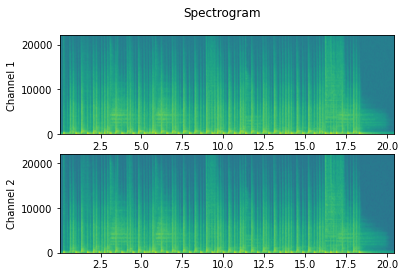

In [14]:
plot_specgram(to_play[1], 44100)

In [15]:
os.makedirs("checkpoints", exist_ok=True)
# download the pretrained models for the encoder
!wget https://huggingface.co/csteinmetz1/automix-toolkit/resolve/main/encoder.ckpt
!mv encoder.ckpt checkpoints/encoder.ckpt
encoder_ckpt_path = "checkpoints/encoder.ckpt"

--2023-02-07 18:57:47--  https://huggingface.co/csteinmetz1/automix-toolkit/resolve/main/encoder.ckpt
Resolving huggingface.co (huggingface.co)... 54.235.118.239, 3.231.67.228, 2600:1f18:147f:e850:e203:c458:10cd:fc3c, ...
Connecting to huggingface.co (huggingface.co)|54.235.118.239|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.huggingface.co/repos/ec/ee/ecee38df047e3f2db1bd8c31a742f3a08f557470cd67cb487402a9c3ed91b5ea/90c13ab981715e1fc1ae079f15fb6da36d61d6aad29ae5dddd4d3bfd4594546a?response-content-disposition=attachment%3B+filename*%3DUTF-8%27%27encoder.ckpt%3B+filename%3D%22encoder.ckpt%22%3B&Expires=1676055468&Policy=eyJTdGF0ZW1lbnQiOlt7IlJlc291cmNlIjoiaHR0cHM6Ly9jZG4tbGZzLmh1Z2dpbmdmYWNlLmNvL3JlcG9zL2VjL2VlL2VjZWUzOGRmMDQ3ZTNmMmRiMWJkOGMzMWE3NDJmM2EwOGY1NTc0NzBjZDY3Y2I0ODc0MDJhOWMzZWQ5MWI1ZWEvOTBjMTNhYjk4MTcxNWUxZmMxYWUwNzlmMTVmYjZkYTM2ZDYxZDZhYWQyOWFlNWRkZGQ0ZDNiZmQ0NTk0NTQ2YT9yZXNwb25zZS1jb250ZW50LWRpc3Bvc2l0aW9uPSoiLCJDb25kaXRpb24i

In [17]:
class ResBlock(nn.Module):

  def __init__(self, input: int, output: int, kernel=3, stride=2, pad=1) -> None:
    super().__init__()
    self.input = input
    self.output = output
    self.conv_layer1 = nn.Conv2d(in_channels=input, out_channels=output, 
                                 kernel_size=kernel, stride=stride,
                                 padding=pad)
    self.conv_layer2 = nn.Conv2d(in_channels=output, out_channels=output,
                                 kernel_size=kernel, stride=stride,
                                 padding=pad)
    self.relu = nn.ReLU()

  def should_apply_shortcut(self):
    return self.input != self.output
  
  def forward(self, x):
    residual = x
    f_x = self.conv_layer1(x)
    f_x = self.relu(f_x)
    f_x = self.conv_layer2(f_x)
    f_x = self.relu(f_x)
    if self.should_apply_shortcut():
      f_x += residual
    return f_x

In [39]:
resblock = ResBlock(1, 1)
dummy = torch.ones((1, 1, 1, 1))
resblock(dummy)

tensor([[[[0.1906]]]], grad_fn=<ReluBackward0>)

In [ ]:
class ShortChunkCNN_Res(nn.Moudule):

  def __init__(self, sr, channel_number=128,  n_fft=512, f_min=0.0,
        f_max=8000.0, n_mels=128, n_class=50, ckpt_path: str = None) -> None:
    super().__init__()
    self.sr, self.channel_number, self.n_fft, self.f_min = sr, channel_number, n_fft, f_min
    self.f_max, self.n_mels, self.n_class, self.ckpt_path = f_max, n_mels, n_class, ckpt_path
    self.spectogram = torchaudio.transforms.MelSpectrogram(sample_rate=16000, 
                                                     n_fft=n_fft, 
                                                     f_min=f_min, f_max=f_max, 
                                                     n_mels=n_mels)
    self.amplitude_to_db = torchaudio.transforms.AmplitudeToDB()
    self.resample = torchaudio.transforms.Resample(sr, 16000)
    
